Sources: 

https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-lstm

https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/tree/master/tensorflow-rnn-tutorial

https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/


TODOs:

split between train and evaluate.

Results / learnings:

1. Using "msle" instead of "mse" reduces the lower values of y_hat. msle can only be used if y_hat values are very close to 1.
2. Loss results are very sensitive to model architecture and choice of hyperparameters 


# RNN using generated data & keras

In [1]:
import numpy as np

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import GRU, LSTM

Using TensorFlow backend.


In [2]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

In [4]:
tf.__version__

'1.12.0'

In [5]:
keras.__version__

'2.2.4'

<a name="assignment1"></a>
## Generate a wave-form dataset

In [6]:
WAVEFORM_SELECT = 0 # select 0, 1 or 2

def create_time_series(datalen):
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55)]
    freq1, freq2 = frequencies[WAVEFORM_SELECT]
    noise = [np.random.random()*0.1 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

DATA_SEQ_LEN = 2048*128
data = create_time_series(DATA_SEQ_LEN)


In [7]:
data.shape

(262144,)

In [8]:
data[:-1].shape

(262143,)

In [9]:
data[1:].shape

(262143,)

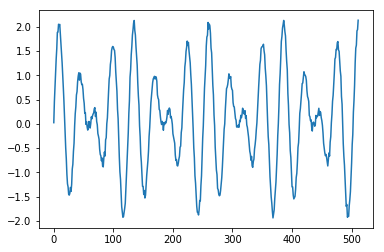

In [10]:
plt.plot(data[:512])
plt.show()

## Time series generator

task: previous observations predict next values in sequences

In [11]:
SEQLEN = 128        # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

n_x = 1             # number of X features (one dimensional time series)

In [12]:
data_gen = TimeseriesGenerator(data, data, length=SEQLEN, batch_size=BATCHSIZE)

In [13]:
data_gen

In [14]:
# number of samples prepared by the data generator for this time series

len(data_gen)

8188

In [15]:
x,y = data_gen[0]  # batch number 0

In [16]:
x.shape

(32, 128)

In [17]:
y.shape

(32,)

In [18]:
x[0, 120:]

array([-1.63792479, -1.35298705, -1.0995301 , -0.76208365, -0.52198535,
       -0.19207929,  0.21735656,  0.47646475])

In [19]:
x[1, 120:]

array([-1.35298705, -1.0995301 , -0.76208365, -0.52198535, -0.19207929,
        0.21735656,  0.47646475,  0.96347219])

In [20]:
x[2, 120:]

array([-1.0995301 , -0.76208365, -0.52198535, -0.19207929,  0.21735656,
        0.47646475,  0.96347219,  1.11585343])

In [21]:
x[3, 120:]

array([-0.76208365, -0.52198535, -0.19207929,  0.21735656,  0.47646475,
        0.96347219,  1.11585343,  1.42319226])

In [22]:
y[0]

0.9634721875190735

In [23]:
y[1]

1.1158534288406372

In [24]:
y[2]

1.4231922626495361

## Simple model

Two hidden layers and an output (prediction) layer.

In [25]:
model = Sequential()
model.add(Dense(64, activation='tanh', input_dim=SEQLEN))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_x))
model.compile(optimizer='adam', loss=['mse'], metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 10,369
Trainable params: 10,369
Non-trainable params: 0
_________________________________________________________________


steps_per_epoch = len(data_gen) is default.

In [27]:
model.fit_generator(data_gen, epochs=2, use_multiprocessing=True, verbose=2)

Epoch 1/2
 - 15s - loss: 0.0264 - acc: 0.0000e+00
Epoch 2/2
 - 15s - loss: 0.0243 - acc: 0.0000e+00


In [29]:
model.evaluate_generator(data_gen, use_multiprocessing=True, verbose=1)

8188/8188 [==============================] - 12s 1ms/step


[0.00604927878828904, 0.0]

### loss graph

In [30]:
history = model.history

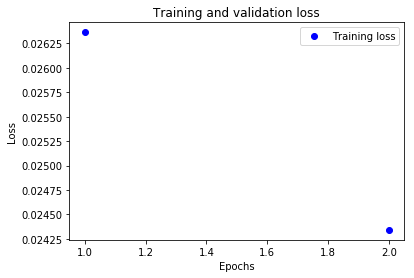

In [33]:
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

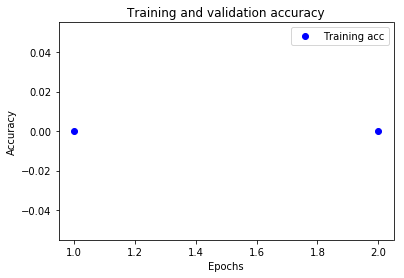

In [36]:
plt.clf()   # clear figure
#acc_values = history_dict['acc']
#val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Predictions - simple model

For each step feed `y_hat` into the `test_data` as the last observation, and remove the first obs from `test_data`

... then plot the result and view if it looks like the normal data

Note, in this case it is assumed that the prediction of interest is only one single observation ahead (and not several observations ahead)

In [26]:
test_data = create_time_series(SEQLEN+1)

test_gen = TimeseriesGenerator(test_data, test_data, length=SEQLEN, batch_size=1, end_index=SEQLEN)

y_hat = model.predict_generator(test_gen, use_multiprocessing=True, verbose=1,max_queue_size=10)


1/1 [==============================] - 0s 71ms/step


In [27]:
test_data[120:]

array([-1.5501554 , -1.2724109 , -1.1331741 , -0.75282955, -0.56562096,
       -0.08172829,  0.31723708,  0.5030371 ,  0.8595315 ], dtype=float32)

In [28]:
y_hat

array([[0.8797145]], dtype=float32)

In [29]:
test_data = create_time_series(SEQLEN+1)

test_gen = TimeseriesGenerator(test_data, test_data, length=SEQLEN, batch_size=1, end_index=SEQLEN)

y_hat = model.predict_generator(test_gen, use_multiprocessing=True, verbose=1,max_queue_size=10)

1/1 [==============================] - 0s 13ms/step


In [30]:
test_data[120:]

array([-1.5936084 , -1.3030183 , -1.1085413 , -0.7280424 , -0.4847358 ,
       -0.06531848,  0.28013787,  0.6093054 ,  0.9204104 ], dtype=float32)

In [31]:
y_hat

array([[0.8506429]], dtype=float32)

In [31]:
test_data = create_time_series(SEQLEN*3)  # three cycles

output = []
actual = []

for i in range(150):
    actual.append(test_data[SEQLEN + i])
    
    tmp = test_data[0+i: SEQLEN+1+i]
    test_gen = TimeseriesGenerator(tmp, tmp, length=SEQLEN, batch_size=1, end_index=SEQLEN)

    y_hat = model.predict_generator(test_gen, use_multiprocessing=True, verbose=1, max_queue_size=10)
    output.append(y_hat[0])

1/1 [==============================] - 0s 9ms/step


In [32]:
output = np.array(output)

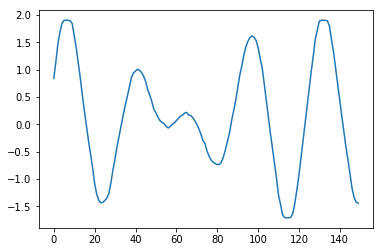

In [33]:
plt.plot(output)
plt.show()

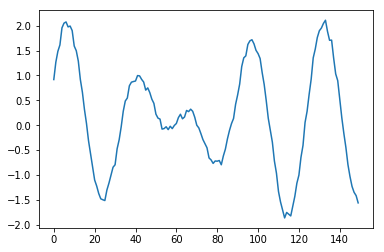

In [34]:
plt.plot(actual)
plt.show()

Compare with e.g. same-as-last observation dummy model

In [35]:
np.histogram(output)

(array([14,  9, 13, 15, 21, 22, 10, 16, 11, 19]),
 array([-1.71052003, -1.34926782, -0.9880156 , -0.62676339, -0.26551118,
         0.09574103,  0.45699325,  0.81824546,  1.17949767,  1.54074988,
         1.9020021 ]))

In [36]:
np.histogram(actual)

(array([11, 11, 15, 15, 19, 21, 18, 10, 17, 13]),
 array([-1.86597991, -1.46828964, -1.07059937, -0.67290909, -0.27521882,
         0.12247145,  0.52016172,  0.917852  ,  1.31554227,  1.71323254,
         2.11092281]))

# GRU

### preparation

The LSTM expects data input to have the shape `[samples (m), timesteps (T_x), features (n_x)]`, whereas the generator described so far is providing lag observations as features or the shape [samples, features].

The univariate time series is prepared for the generator: from `[T_x, ]` to `[T_x, n_x]` for illustration below with 10 time steps and 1 feature.

In [38]:
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_features = 1
series.reshape((len(series), n_features))

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [39]:
n_input = 3
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)


In [40]:
generator[0]

(array([[1., 2., 3.],
        [2., 3., 4.],
        [3., 4., 5.],
        [4., 5., 6.],
        [5., 6., 7.],
        [6., 7., 8.],
        [7., 8., 9.]]), array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [41]:
data.shape

(262144,)

In [39]:
data = data.reshape((len(data), n_x))

In [40]:
data.shape

(262144, 1)

In [95]:
n_x

1

### Mini model

In [65]:
# define dataset
T_x = 1000
series = np.arange(T_x)

# reshape to [, 1]
n_features = 1
series = series.reshape(T_x, n_features)

# define generator
n_input = 10
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=10)



In [66]:
generator[0][0].shape

(10, 10, 1)

In [69]:
# define model
model = Sequential()
model.add(GRU(32, activation='relu', input_shape=(n_input, n_features), return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit_generator(generator, epochs=50, verbose=2, shuffle=False)


Epoch 1/50
 - 2s - loss: 71480.1214
Epoch 2/50
 - 1s - loss: 135.6175
Epoch 3/50
 - 1s - loss: 15.2324
Epoch 4/50
 - 1s - loss: 2.4894
Epoch 5/50
 - 1s - loss: 2.3459
Epoch 6/50
 - 1s - loss: 1.8895
Epoch 7/50
 - 1s - loss: 1.3024
Epoch 8/50
 - 1s - loss: 1.1300
Epoch 9/50
 - 1s - loss: 0.7351
Epoch 10/50
 - 1s - loss: 0.6063
Epoch 11/50
 - 1s - loss: 0.4114
Epoch 12/50
 - 1s - loss: 0.3586
Epoch 13/50
 - 1s - loss: 0.2430
Epoch 14/50
 - 1s - loss: 0.1406
Epoch 15/50
 - 1s - loss: 0.1116
Epoch 16/50
 - 1s - loss: 0.0611
Epoch 17/50
 - 1s - loss: 0.0557
Epoch 18/50
 - 1s - loss: 0.0394
Epoch 19/50
 - 1s - loss: 0.0315
Epoch 20/50
 - 1s - loss: 0.0853
Epoch 21/50
 - 1s - loss: 0.6631
Epoch 22/50
 - 1s - loss: 3.4376
Epoch 23/50
 - 1s - loss: 79.6520
Epoch 24/50
 - 1s - loss: 1.5700
Epoch 25/50
 - 1s - loss: 1.0521
Epoch 26/50
 - 1s - loss: 9.3096
Epoch 27/50
 - 1s - loss: 0.3902
Epoch 28/50
 - 1s - loss: 0.3713
Epoch 29/50
 - 1s - loss: 0.3289
Epoch 30/50
 - 1s - loss: 0.2514
Epoch 31/50

In [70]:
# make a one step prediction out of sample
x_input = np.array([2000,2001,2002,2003,2004,2005,2006,2007,2008,2009]).reshape((1,n_input,n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

1/1 [==============================] - 1s 679ms/step
[[2010.6494]]


### GRU model - 2 layer

source: https://keras.io/getting-started/faq/#how-can-i-use-stateful-rnns

In [41]:
data_gen = TimeseriesGenerator(data, data, length=SEQLEN, batch_size=BATCHSIZE)

In [42]:
len(data_gen)

8188

In [43]:
data_gen[0][0].shape

(32, 128, 1)

In [47]:
# model

# source: https://keras.io/getting-started/sequential-model-guide/

model = Sequential()
model.add(GRU(128, activation='tanh', dropout=0.2, input_shape=(SEQLEN, n_x), return_sequences=True))
model.add(GRU(64, activation='tanh', dropout=0.2, return_sequences=False))
model.add(Dense(16, activation='tanh'))
model.add(Dense(n_x))
model.compile(optimizer='adam', loss=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 128, 128)          49920     
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 88,033
Trainable params: 88,033
Non-trainable params: 0
_________________________________________________________________


In [48]:
# fit model (10 minutes on laptop)

model.fit_generator(data_gen, epochs=1, verbose=1, use_multiprocessing=True)

Epoch 1/1
8188/8188 [==============================] - 1343s 164ms/step - loss: 0.0423


### predict with 1-layer

In [53]:
test_data = create_time_series(SEQLEN*3)  # three cycles
test_data = test_data.reshape((len(test_data), n_x))

output = []
actual = []

for i in range(150):
    actual.append(test_data[SEQLEN + i])
    
    tmp = test_data[0+i: SEQLEN+1+i]
    test_gen = TimeseriesGenerator(tmp, tmp, length=SEQLEN, batch_size=1, end_index=SEQLEN)

    y_hat = model.predict_generator(test_gen, use_multiprocessing=True, verbose=1, max_queue_size=10)
    output.append(y_hat[0])

1/1 [==============================] - 0s 44ms/step


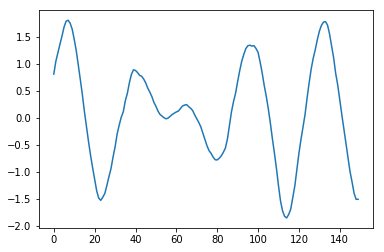

In [54]:
output = np.array(output)
plt.plot(output)
plt.show()

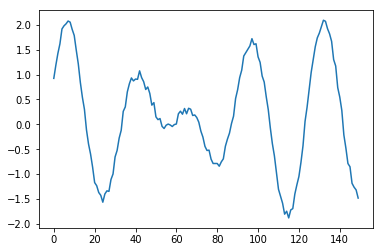

In [55]:
plt.plot(actual)
plt.show()

In [56]:
np.histogram(output)

(array([10, 10,  8, 19, 11, 32, 15, 16, 15, 14]),
 array([-1.85893786, -1.49272108, -1.1265043 , -0.76028752, -0.39407074,
        -0.02785397,  0.33836281,  0.70457959,  1.07079637,  1.43701315,
         1.80322993]))

In [57]:
np.histogram(actual)

(array([ 7, 16, 14, 13, 20, 21, 16, 14, 14, 15]),
 array([-1.88007092, -1.48309994, -1.08612895, -0.68915796, -0.29218698,
         0.10478401,  0.501755  ,  0.89872599,  1.29569697,  1.69266796,
         2.08963895]))

## Save & load model

## Save the entire model

The entire model can be saved to a file that contains the weight values, the model's configuration, and even the optimizer's configuration (depends on set up). This allows you to checkpoint a model and resume training later—from the exact same state—without access to the original code.

Saving a fully-functional model is very useful—you can load them in **TensorFlow.js** ([HDF5](https://js.tensorflow.org/tutorials/import-keras.html), [Saved Model](https://js.tensorflow.org/tutorials/import-saved-model.html)) and then train and run them in web browsers, or convert them to run on mobile devices using **TensorFlow Lite** ([HDF5](https://www.tensorflow.org/lite/convert/python_api#exporting_a_tfkeras_file_), [Saved Model](https://www.tensorflow.org/lite/convert/python_api#exporting_a_savedmodel_))

**You need to use a keras.optimizer to restore the optimizer state from an HDF5 file.**

In [110]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 64)                12672     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Save entire model to a HDF5 file
model.save('GRU-2-layer.h5')

In [50]:
# To reuse

# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('GRU-2-layer.h5')
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 128, 128)          49920     
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 88,033
Trainable params: 88,033
Non-trainable params: 0
_________________________________________________________________


In [51]:
new_model.compile(optimizer='adam', loss=['msle'])

In [52]:
new_model.evaluate_generator(data_gen, use_multiprocessing=True, verbose=1)

8188/8188 [==============================] - 415s 51ms/step


0.004645701346849956